In [27]:
from torchvision import datasets
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_folder = 'CARD 20'

fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [28]:
from imgaug import augmenters as iaa

# define a augmentação dos dados
aug = iaa.Sequential([
    iaa.Affine(translate_px={'x':(-10, 10)}, mode='constant')
])


In [29]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y, aug = None):
        self.x, self.y = x, y
        self.aug = aug

    def __getitem__(self, ix):
        x = self.x[ix]
        y = self.y[ix]
        return x, y

    def __len__(self):
        return len(self.x)

    def collate_fn(self, batch):
        ims, classes = list(zip(*batch))
        if self.aug:
            ims_np = np.array([tensor.numpy() for tensor in ims])
            ims = self.aug.augment_images(images = ims_np)

        ims = torch.tensor(ims)[:, None, :, :].to(device) / 255
        classes = torch.tensor(classes).to(device)
        return ims, classes

In [30]:
from torch.optim import SGD, Adam

# adicionei camadas de dropout para testes diferenciados
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size = 3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Dropout(0.15),
        nn.Conv2d(64, 128, kernel_size = 3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Dropout(0.15),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Dropout(0.15),
        nn.Linear(256, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss() # função de perda
    optimizer = Adam(model.parameters(), lr = 1e-3) # otimizador

    return model, loss_fn, optimizer

In [31]:
# treina o modelo
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()

    return batch_loss.item()

In [32]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets, aug = aug) # dataset de treinamento
    trn_dl = DataLoader(train, batch_size = 64, shuffle = True,
                        collate_fn = train.collate_fn)

    val = FMNISTDataset(val_images, val_targets) # dataset de validação
    val_dl = DataLoader(val, batch_size = 64, shuffle = True,
                        collate_fn = val.collate_fn)

    return trn_dl, val_dl

In [33]:
trn_dl, val_dl = get_data()
model, loss_fn, opt = get_model()

for epoch in range(5):
    print(epoch)
    for ix, batch in enumerate(trn_dl): # itera sobre os dados
        x, y = batch
        batch_loss = train_batch(x, y, model, opt, loss_fn) # treina o modelo

0
1
2
3
4


In [34]:
print(tr_images.shape)

torch.Size([60000, 28, 28])


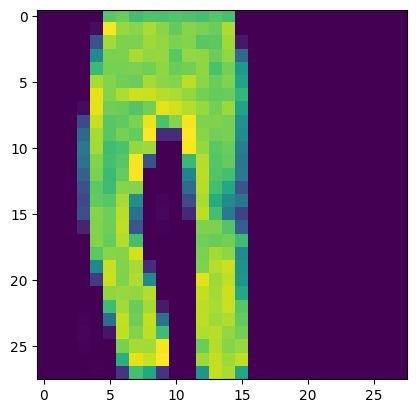

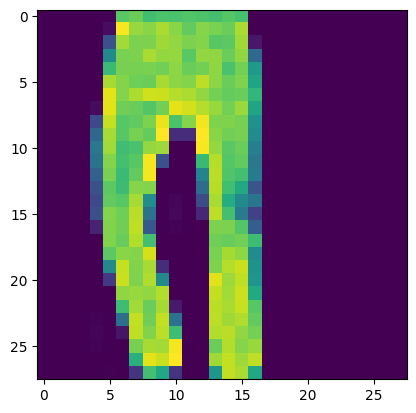

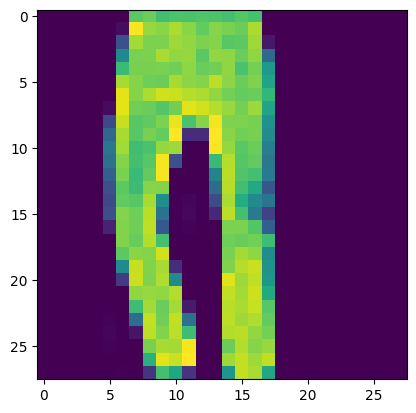

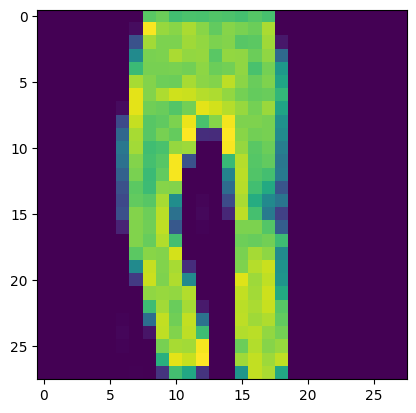

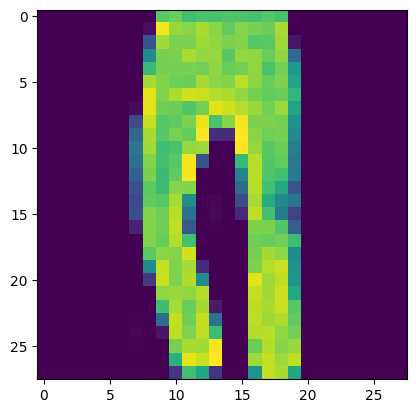

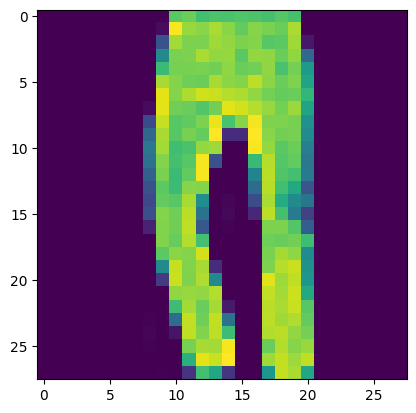

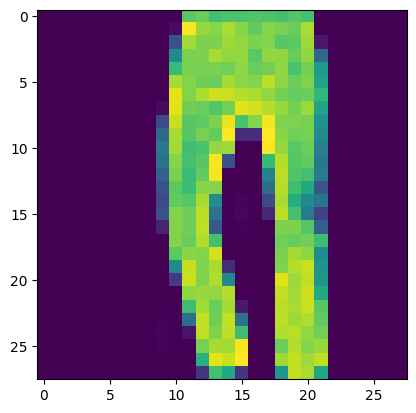

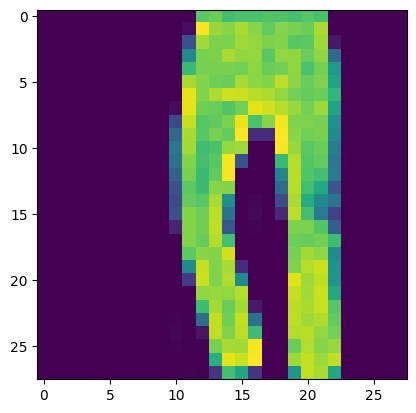

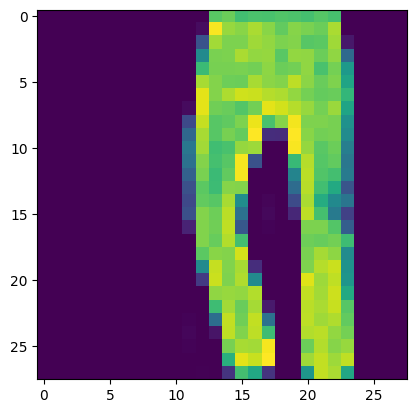

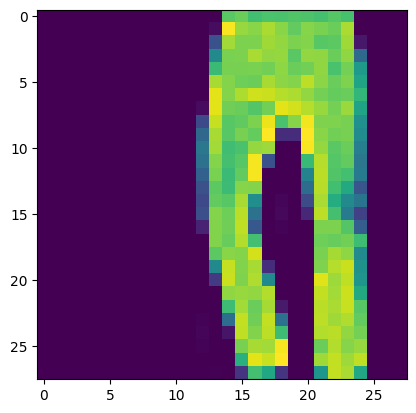

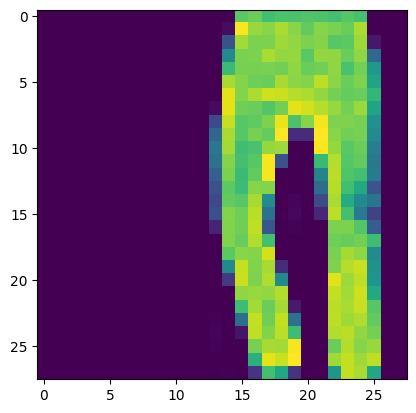

In [35]:
preds = []
ix = 24300

for px in range(-5, 6):
    img = tr_images[ix]/255 # normaliza
    img = img.view(28, 28) # redimensiona
    img2 = np.roll(img, px, axis = 1)
    img3 = torch.tensor(img2).view(-1, 1, 28, 28).to(device) # converte pra tensor
    np_output = model(img3).cpu().detach().numpy()
    pred = np.exp(np_output) / np.sum(np.exp(np_output))
    preds.append(pred) # adiciona a previsão na lista

    plt.imshow(img2)
    plt.show()